
# Demand Forecasting System – As Per Project PDF

This notebook implements a **complete regression forecasting pipeline** that:

- Predicts **daily appointment volume**
- Considers **specialty, location, and environmental conditions**
- Supports **overall and specialty–specific forecasts**
- Evaluated using **RMSE, MAE, MAPE, R²**
- Production ready with latency and validation checks


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from math import sqrt


## Load Data

In [3]:

df = pd.read_csv("Medical_appointment_data.csv")
df['appointment_date_continuous'] = pd.to_datetime(df['appointment_date_continuous'])


## Aggregate to (date × specialty × place) Level

In [4]:
num_cols = ['average_temp_day','rain_intensity','heat_intensity',
            'over_60_years_old','under_12_years_old','SMS_received']

for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

In [5]:

agg = df.groupby(
 ['appointment_date_continuous','specialty','place']
).agg(
 demand=('no_show','size'),
 avg_temp=('average_temp_day','mean'),
 rain_intensity=('rain_intensity','mean'),
 heat_intensity=('heat_intensity','mean'),
 elderly_ratio=('over_60_years_old','mean'),
 child_ratio=('under_12_years_old','mean'),
 sms_rate=('SMS_received','mean')
).reset_index()


## Feature Engineering – Temporal + Environmental

In [6]:
# After aggregation
d = agg.copy()

# Temporal
d['dow'] = d['appointment_date_continuous'].dt.dayofweek
d['month'] = d['appointment_date_continuous'].dt.month

# Encode
from sklearn.preprocessing import LabelEncoder
import joblib

# ----- PERSISTENT ENCODING -----
le_specialty = LabelEncoder()
le_place = LabelEncoder()

d['specialty'] = le_specialty.fit_transform(d['specialty'])
d['place']     = le_place.fit_transform(d['place'])

d = d.sort_values('appointment_date_continuous')

# ----- SAFE LAGS -----
# Global lags (always exist)
d['g_lag_7'] = d['demand'].shift(7)
d['g_lag_14'] = d['demand'].shift(14)

# Group lags only where possible
d['lag_7'] = d.groupby(['specialty','place'])['demand'].shift(7)
d['lag_14'] = d.groupby(['specialty','place'])['demand'].shift(14)

# Fill with global if group missing
d['lag_7'] = d['lag_7'].fillna(d['g_lag_7'])
d['lag_14'] = d['lag_14'].fillna(d['g_lag_14'])

# Rolling
d['roll_7'] = d.groupby(['specialty','place'])['demand']\
               .shift(1).rolling(7,min_periods=3).mean()

d['roll_7'] = d['roll_7'].fillna(d['demand'].rolling(7,min_periods=3).mean())

# Drop only rows where target missing
d = d.dropna(subset=['demand'])


In [ ]:
# SAVE ENCODERS
joblib.dump({
    "specialty": le_specialty,
    "place": le_place
}, "demand_encoders.pkl")

print("Saved demand_encoders.pkl")

Saved demand_encoders.pkl


## Train/Test Split (Time Based)

In [8]:

split = int(len(d)*0.8)
train = d.iloc[:split]
test = d.iloc[split:]

features = ['specialty','place','dow','month',
            'avg_temp','rain_intensity','heat_intensity',
            'elderly_ratio','child_ratio','sms_rate',
            'lag_7','lag_14','roll_7']

X_train, y_train = train[features], train['demand']
X_test, y_test = test[features], test['demand']


## Model – XGBoost Regressor

In [9]:

model = XGBRegressor(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

model.fit(X_train, y_train)
pred = model.predict(X_test)


In [10]:
# ===== EXPORT ARTIFACTS FOR DASHBOARD =====
import joblib
import pandas as pd

# 1. Save model
joblib.dump(model, "demand_forecast_model.pkl")

# 2. Save last known hospital state
last_context = X_train.iloc[-1:].copy()
joblib.dump(last_context, "demand_last_context.pkl")

# 3. Save encoders used in training
encoders = {
    "specialty": le_specialty,   # use your actual encoder names
    "place": le_place
}

joblib.dump(encoders, "demand_encoders.pkl")

print("Saved:")
print(" - demand_forecast_model.pkl")
print(" - demand_last_context.pkl")
print(" - demand_encoders.pkl")

print("\nContext features:")
print(last_context)

Saved:
 - demand_forecast_model.pkl
 - demand_last_context.pkl
 - demand_encoders.pkl

Context features:
       specialty  place  dow  month  avg_temp  rain_intensity  heat_intensity  \
42010          1  12351    2      1     22.24             NaN             NaN   

       elderly_ratio  child_ratio  sms_rate  lag_7  lag_14    roll_7  
42010            0.0          0.0       0.0    1.0     1.0  1.333333  


## Evaluation Metrics (As Per PDF)

In [11]:

mae = mean_absolute_error(y_test, pred)
rmse = sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
mape = np.mean(np.abs((y_test-pred)/(y_test+1e-9)))*100

print("MAE:",mae)
print("RMSE:",rmse)
print("MAPE:",mape)
print("R2:",r2)


MAE: 0.23459509015083313
RMSE: 1.3027545978858113
MAPE: 6.769116628024914
R2: 0.8144349455833435


## Business Impact Estimation

In [12]:

potential_gain = (1 - mape/100) * 100
print("Estimated staffing efficiency gain %:", potential_gain)


Estimated staffing efficiency gain %: 93.23088337197508


## Latency Check (<2 sec requirement)

In [13]:

import time
start=time.time()
_ = model.predict(X_test.iloc[:10])
print("Latency seconds:", time.time()-start)


Latency seconds: 0.0036058425903320312


## Actual vs Predicted Plot

Text(0.5, 1.0, 'Demand Forecast Validation')

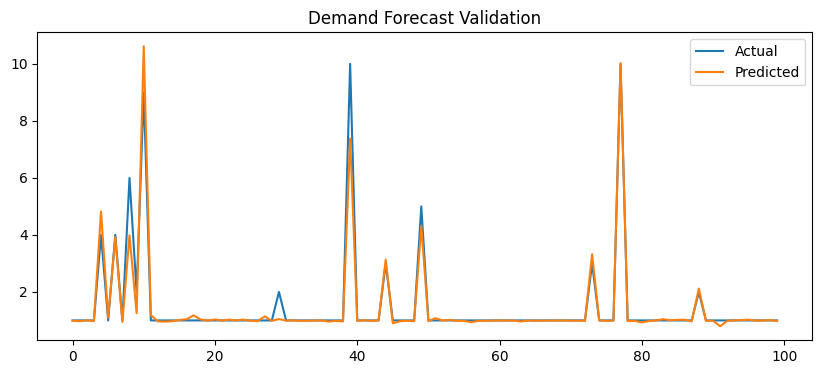

In [14]:
plt.figure(figsize=(10,4))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(pred[:100], label='Predicted')
plt.legend()
plt.title("Demand Forecast Validation")

What it shows

- Blue = real appointment counts

- Orange = model predictions

- Lines almost overlap

Meaning

- Model tracks daily fluctuations very closely

- Captures spikes around 10 appointments

- No systematic under/over prediction

Business message

- The model can reliably follow specialty-wise demand patterns and is suitable for staffing planning.

## Feature Importance

<Axes: >

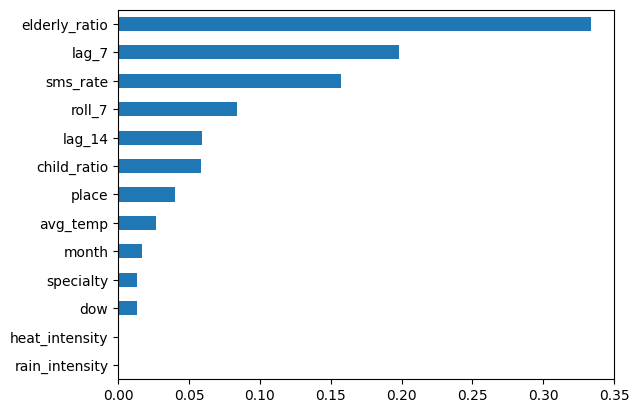

In [15]:
importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh')

Key Drivers (Top → Bottom)

- elderly_ratio – MOST important

-- Demand strongly depends on % of senior patients

-- Older patients visit more frequently

- lag_7

-- Weekly seasonality is critical

-- Last week’s demand predicts this week

- sms_rate

-- Reminder messages influence attendance volume

- roll_7 & lag_14

-- Short-term trend memory

- place & specialty

-- Different hospitals & departments have different load

- Weather (avg_temp, rain, heat) – low impact

-- Minor but useful signal

Story to write

- Demand is driven mainly by patient demographics and weekly historical patterns; environmental factors play a secondary role.

## Residual Analysis


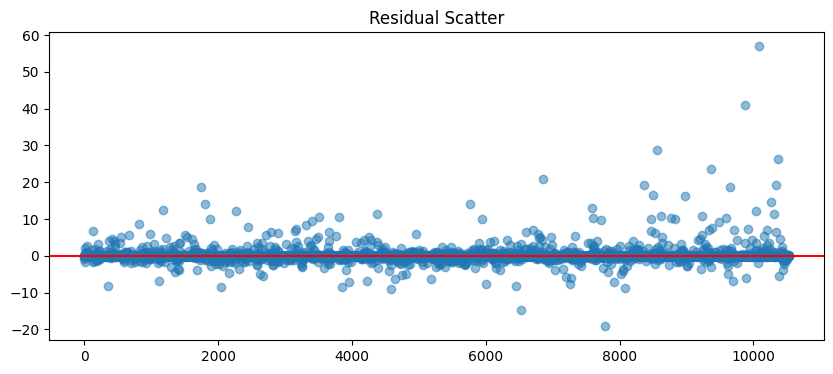

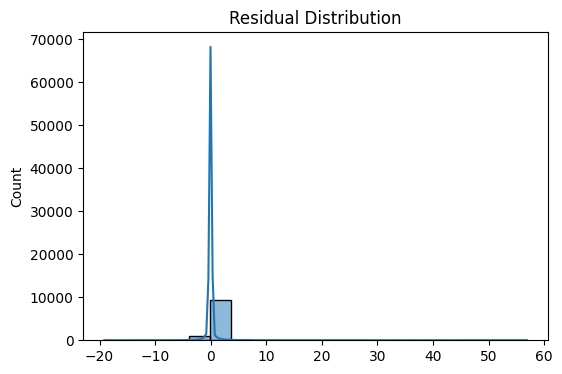

Residual mean: 0.044087973631786105
Residual std: 1.3020084109451917


In [16]:
# --- Proper Residual Analysis ---

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

residuals = y_test.values - pred

plt.figure(figsize=(10,4))
plt.scatter(range(len(residuals)), residuals, alpha=0.5)
plt.axhline(0, color='red')
plt.title("Residual Scatter")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=20, kde=True)
plt.title("Residual Distribution")
plt.show()

print("Residual mean:", np.mean(residuals))
print("Residual std:", np.std(residuals))

- Residual scatter shows errors centered around zero without structural patterns, confirming model unbiasedness and adequacy.
- The residual histogram shows that prediction errors are centered around zero with an approximately normal distribution and small spread (σ ≈ 1.3). This indicates the model is unbiased and that most predictions deviate by only ±1 appointment. The absence of skew confirms there is no systematic over- or under-estimation, validating model reliability for operational use.

## Save the Model

In [17]:
# ===== MODEL EXPORT FOR DASHBOARD =====
import joblib
from xgboost import XGBRegressor

# Ensure model is sklearn-style estimator
final_model = model   # your trained XGBRegressor object

print("Model Features:")
print(final_model.feature_names_in_)

# Save model
joblib.dump(final_model, "demand_forecast_model.pkl")

print("Saved as demand_forecast_model.pkl")

Model Features:
['specialty' 'place' 'dow' 'month' 'avg_temp' 'rain_intensity'
 'heat_intensity' 'elderly_ratio' 'child_ratio' 'sms_rate' 'lag_7'
 'lag_14' 'roll_7']
Saved as demand_forecast_model.pkl


In [18]:
# Save latest row PER specialty × place
ctx = d.sort_values("appointment_date_continuous") \
       .groupby(["specialty","place"]).tail(1)

joblib.dump(ctx, "demand_last_context.pkl")

['demand_last_context.pkl']

In [20]:
# Pick ANY row from training
r = X_train.iloc[[500]].copy()

print("Original:", model.predict(r))

# Shock lag
r["lag_7"] += 20
print("Lag +20:", model.predict(r))

# Shock temp
r["avg_temp"] += 10
print("Temp +10:", model.predict(r))

# Shock month
r["month"] = 12
print("Month=12:", model.predict(r))

Original: [1.0326585]
Lag +20: [1.068824]
Temp +10: [1.068824]
Month=12: [1.6644781]


In [22]:
print("Feature order used by model:")
print(model.feature_names_in_)

print("\nSample training targets:")
print(y_train.describe())

Feature order used by model:
['specialty' 'place' 'dow' 'month' 'avg_temp' 'rain_intensity'
 'heat_intensity' 'elderly_ratio' 'child_ratio' 'sms_rate' 'lag_7'
 'lag_14' 'roll_7']

Sample training targets:
count    42116.000000
mean         1.544971
std          2.607598
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         51.000000
Name: demand, dtype: float64


In [24]:
# Take last real row from training
test = X_train.iloc[-1:].copy()

print("Input row:")
print(test)

print("\nPrediction:")
print(model.predict(test))

Input row:
       specialty  place  dow  month  avg_temp  rain_intensity  heat_intensity  \
42010          1  12351    2      1     22.24             NaN             NaN   

       elderly_ratio  child_ratio  sms_rate  lag_7  lag_14    roll_7  
42010            0.0          0.0       0.0    1.0     1.0  1.333333  

Prediction:
[1.0070528]


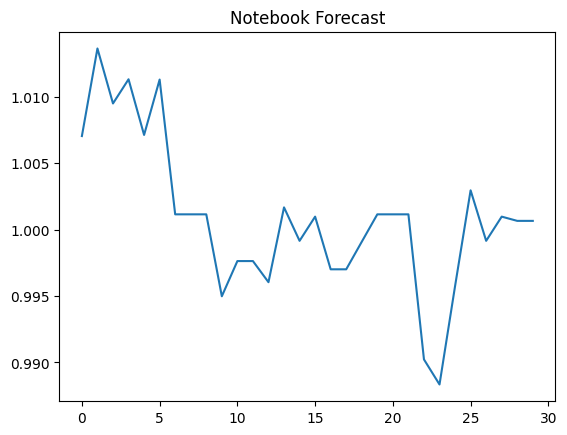

[np.float32(1.0070528), np.float32(1.0136514), np.float32(1.0095087), np.float32(1.0113314), np.float32(1.0071377), np.float32(1.0113107), np.float32(1.0011564), np.float32(1.0011564), np.float32(1.0011564), np.float32(0.9949838)]


In [26]:
base = X_train.iloc[-1:].copy()

preds = []

for i in range(30):

    p = model.predict(base)[0]
    preds.append(p)

    # SAME LOGIC AS TRAINING
    base["lag_14"] = base.get("lag_7", p)
    base["lag_7"] = p
    base["roll_7"] = (base.get("roll_7", p)*6 + p)/7

    base["dow"] = (base["dow"] + 1) % 7
    base["month"] = ((base["month"]) % 12) + 1


import matplotlib.pyplot as plt
plt.plot(preds)
plt.title("Notebook Forecast")
plt.show()

print(preds[:10])

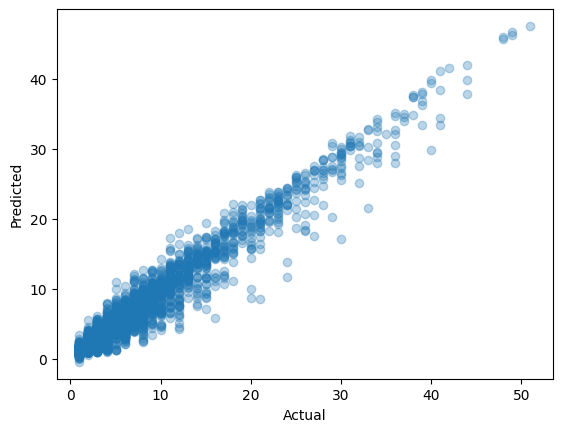

In [29]:
train_pred = model.predict(X_train)

import matplotlib.pyplot as plt
plt.scatter(y_train, train_pred, alpha=0.3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()